In [1]:
import tensorflow as tf
import os

In [2]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## Remove Doddgy files

In [95]:
import cv2
import imghdr

In [96]:
data_dir='Data'

In [97]:
os.listdir(data_dir)

['Angry', 'Happy', 'SAD']

In [98]:
image_exts =['jpg','bmp','png','jpeg']

In [99]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except excetions as ex:
            print('Issue with image'.format(image_path))
            
            
                

In [100]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
data=tf.keras.utils.image_dataset_from_directory('Data')

Found 236 files belonging to 3 classes.


In [102]:
data_iterator = data.as_numpy_iterator()

In [103]:
batch=data_iterator.next()

## Preprocess Data 

In [104]:
data = data.map(lambda x,y:(x/255,y))

In [105]:
batch =data.as_numpy_iterator().next()

In [106]:
batch[1]

array([0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 2, 2,
       2, 1, 0, 0, 1, 2, 0, 1, 0, 2])

In [107]:
#1-Happy #2-Sad #0 -Angry

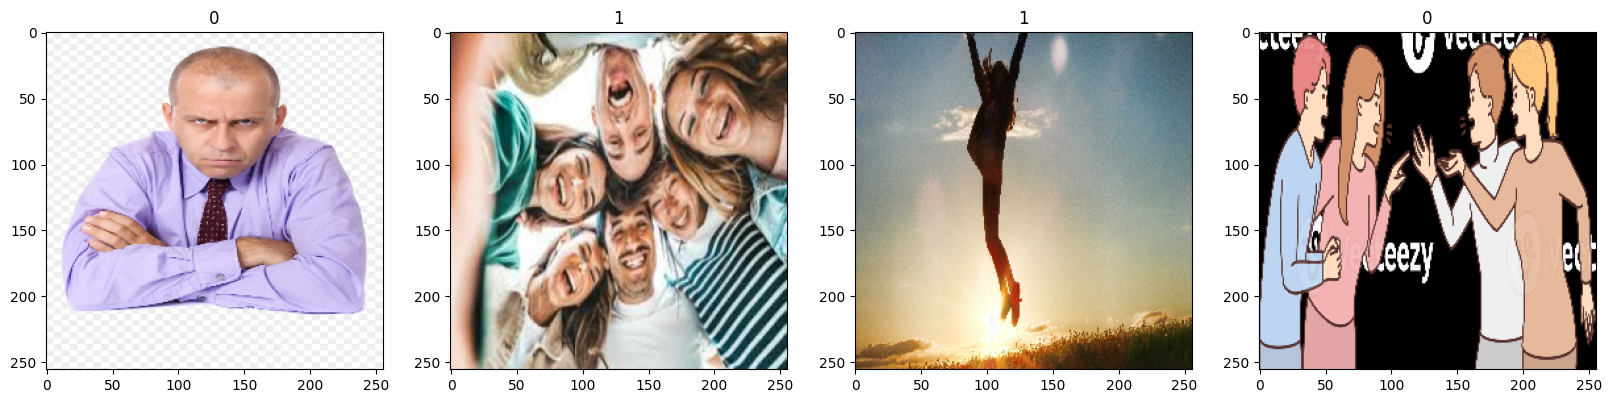

In [108]:
fig, ax =plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


## Split Data

In [116]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [117]:
train =data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [119]:
test_size

1

In [122]:
len(test)

1

## Build Deep learning Model

In [123]:
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten

In [124]:
model =Sequential()

In [125]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [126]:
model.compile('adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['sparse_categorical_accuracy'])

In [127]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

## Train

In [128]:
log_dir ='logs'

In [129]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [130]:
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 5s 525ms/step - loss: 2.5966 - sparse_categorical_accuracy: 0.4187 - val_loss: 1.2093 - val_sparse_categorical_accuracy: 0.4531
Epoch 2/20
5/5 [==============================] - 4s 499ms/step - loss: 1.1605 - sparse_categorical_accuracy: 0.3938 - val_loss: 0.9696 - val_sparse_categorical_accuracy: 0.4219
Epoch 3/20
5/5 [==============================] - 4s 500ms/step - loss: 0.9886 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.0029 - val_sparse_categorical_accuracy: 0.3906
Epoch 4/20
5/5 [==============================] - 4s 516ms/step - loss: 0.9133 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7188
Epoch 5/20
5/5 [==============================] - 4s 505ms/step - loss: 0.8184 - sparse_categorical_accuracy: 0.6687 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 4s 514ms/step - loss: 0.6709 - sparse_categorical_accuracy: 

## Plot Performance

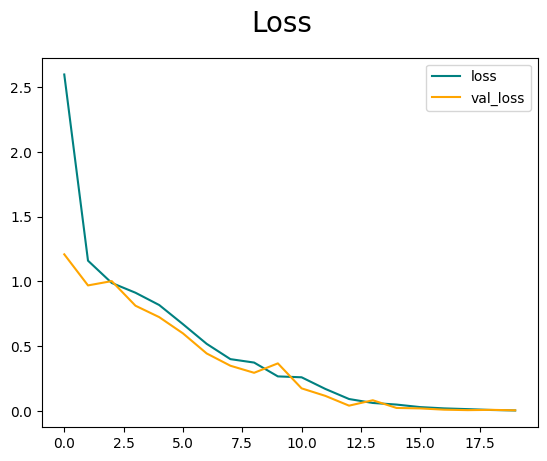

In [131]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper right")
plt.show()

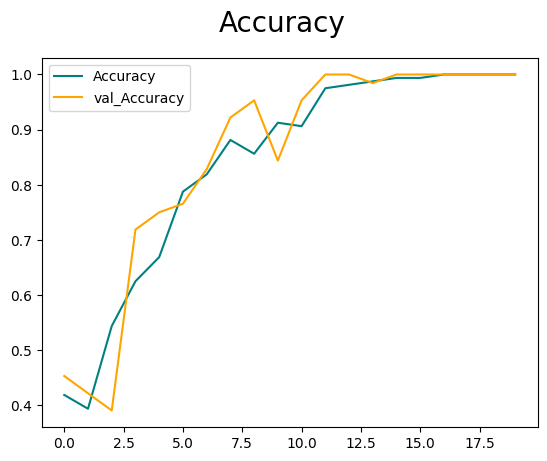

In [132]:
fig = plt.figure()
plt.plot(hist.history['sparse_categorical_accuracy'],color='teal',label='Accuracy')
plt.plot(hist.history['val_sparse_categorical_accuracy'],color='orange',label='val_Accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [133]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [134]:
pre =Precision()
recal = Recall()
BA =BinaryAccuracy()

In [135]:
len(test)

1

In [138]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat =model.predict(X)
#    pre.update_state(y,yhat)
#    BA.update_state(y,yhat)    

1/1 [==============================] - 1s 676ms/step


In [139]:
y

array([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1])

In [140]:
yhat

array([[2.7395195e-09, 9.9998987e-01, 1.0105001e-05],
       [6.9857351e-03, 9.9074507e-01, 2.2691446e-03],
       [8.8573871e-03, 1.9312201e-03, 9.8921144e-01],
       [5.5896689e-05, 9.9984753e-01, 9.6573909e-05],
       [7.8655424e-04, 9.9919802e-01, 1.5434924e-05],
       [3.2892800e-05, 9.9946934e-01, 4.9776613e-04],
       [1.5909869e-10, 9.9999654e-01, 3.4966904e-06],
       [3.0103016e-05, 1.0281843e-04, 9.9986708e-01],
       [1.3322692e-04, 9.9986589e-01, 8.8711101e-07],
       [4.0542774e-04, 9.9954188e-01, 5.2630476e-05],
       [1.6250620e-04, 7.2120005e-05, 9.9976534e-01],
       [7.6911499e-05, 9.9991834e-01, 4.7611616e-06]], dtype=float32)

In [141]:
for i in yhat:
    print(i.argmax(),end=" ")

1 1 2 1 1 1 1 2 1 1 2 1 

In [54]:
##print(f'Precision: {pre.result().numpy()} Recall: {recal.result().numpy()} BinaryAccuracy: {BA.result().numpy()}')

Precision: 0.0 Recall: 0.0 BinaryAccuracy: 0.0


In [142]:
import cv2

In [149]:
image=cv2.imread('sad_test.jpg')

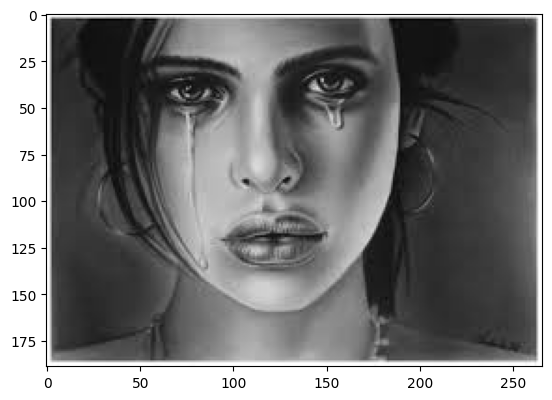

In [150]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

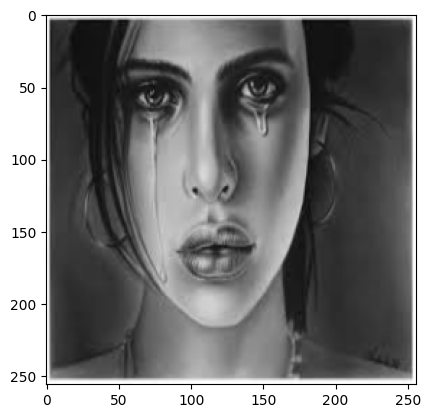

In [151]:
resize = tf.image.resize(image,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [152]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 24ms/step


In [153]:
yhat

array([[0.3245587 , 0.00317265, 0.6722687 ]], dtype=float32)

In [157]:
if yhat.argmax()==0:
    print('The Person is Angry')
elif yhat.argmax()==2:
    print('The Person is Sad')
else:
    print('The person is Happy')

The Person is Sad


## Save the Model

In [158]:
from tensorflow.keras.models import load_model

In [159]:
model.save(os.path.join('models','HappySad.h5'))